# Debug upper level input cut off

In [43]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import *
from cbrain.normalization import *
%matplotlib inline

In [44]:
CAMDIR = '/scratch/05488/tg847872/revision_debug/'

In [45]:
!ls $CAMDIR

001_norm.nc
001_train.nc
atm_in
cam
cam2.debug.rpointer
debug32.cam2.h1.0000-01-01-00000.nc
debug32.cam2.h1.0000-01-01-01800.nc
debug32.cam2.h1.0000-01-01-03600.nc
debug32.cam2.h1.0000-01-01-05400.nc
debug32.cam2.h1.0000-01-01-07200.nc
debug32.cam2.h1.0000-01-01-09000.nc
debug32.cam2.h1.0000-01-01-10800.nc
debug32.cam2.h1.0000-01-01-12600.nc
debug32.cam2.h1.0000-01-01-14400.nc
debug32.cam2.h1.0000-01-01-16200.nc
debug32.cam2.h1.0000-01-01-18000.nc
debug32.cam2.h1.0000-01-01-19800.nc
debug32.cam2.h1.0000-01-01-21600.nc
debug32.cam2.h1.0000-01-01-23400.nc
debug32.cam2.h1.0000-01-01-25200.nc
debug32.cam2.h1.0000-01-01-27000.nc
debug32.cam2.h1.0000-01-01-28800.nc
debug32.cam2.h1.0000-01-01-30600.nc
debug32.cam2.h1.0000-01-01-32400.nc
debug32.cam2.h1.0000-01-01-34200.nc
debug32.cam2.h1.0000-01-01-36000.nc
debug32.cam2.h1.0000-01-01-37800.nc
debug32.cam2.h1.0000-01-01-39600.nc
debug32.cam2.h1.0000-01-01-41400.nc
debug32.cam2.h1.0000-01-01-43200.nc
debug32.cam2.h1.0000-01-01-45000.nc
debug32.

In [46]:
cam_ds = xr.open_mfdataset(CAMDIR+ 'debug.cam2.h1.*.nc', decode_times=False, concat_dim='time')
cam_ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 161)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) float64 0.0 0.02083 0.04167 ... 3.292 3.312 3.333
Dimensions

In [5]:
in_vars = ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

In [47]:
scale_dict = load_pickle('../../nn_config/scale_dicts/002_pnas_scaling.pkl')

In [48]:
input_transform = InputNormalizer(
    xr.open_dataset(f'{/home1/05488/tg847872/saved_models}/001_norm.nc'),
    in_vars,
    'mean', 'maxrs',
    var_cut_off={'QBP':14, 'TBP':14}
)

In [18]:
input_transform.sub.shape

(66,)

In [19]:
#tf.enable_eager_execution()

In [49]:
from cbrain.models import fc_model

In [50]:
model = fc_model(66, 65, [256]*9, 'LeakyReLU')
model.load_weights(
    f'{CAMDIR}weights.h5'
)

## Check network implementation

In [10]:
in_vec = np.concatenate([
    cam_ds.NNQBP.isel(time=1, lat=0, lon=0, lev=slice(14, None)).values,
    cam_ds.NNTBP.isel(time=1, lat=0, lon=0, lev=slice(14, None)).values,
    cam_ds.NNVBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNPS.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNSOLIN.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNSHF.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNLHF.isel(time=1, lat=0, lon=0).values[None],
])[None, :]

In [11]:
in_vec.shape

(1, 66)

In [12]:
in_vec

array([[ 7.7584145e-06,  1.6326150e-05,  3.4403751e-05,  8.0006044e-05,
         2.4521907e-04,  5.1732955e-04,  8.1878394e-04,  1.1264065e-03,
         1.4920642e-03,  1.9111112e-03,  2.2697735e-03,  2.4838927e-03,
         2.7039493e-03,  2.8348863e-03,  2.8195512e-03,  2.9524004e-03,
         2.1715727e+02,  2.1837534e+02,  2.2346922e+02,  2.3037602e+02,
         2.3899352e+02,  2.4771008e+02,  2.5393004e+02,  2.5810934e+02,
         2.6174002e+02,  2.6424826e+02,  2.6566690e+02,  2.6736044e+02,
         2.6911542e+02,  2.7075208e+02,  2.7226617e+02,  2.7363638e+02,
         3.4622788e-01,  2.0125832e-01,  8.3362535e-02, -1.4838111e-01,
        -7.3616683e-01, -1.1581868e+00, -1.5230515e+00, -2.0614483e+00,
        -2.7481334e+00, -3.2969372e+00, -3.8986235e+00, -4.5207772e+00,
        -4.9883423e+00, -4.8059587e+00, -3.6648941e+00, -2.4123576e+00,
        -1.4522421e+00, -1.3796176e+00, -1.6770233e+00, -1.6336905e+00,
        -1.2695681e+00, -1.1857557e+00, -1.2129655e+00, -1.03257

In [13]:
in_vec_trans = input_transform.transform(in_vec); in_vec_trans

array([[-1.9882778e-02, -3.7480053e-02, -5.4051206e-02, -6.7359939e-02,
        -7.6020949e-02, -8.5835069e-02, -1.1026599e-01, -1.5294068e-01,
        -1.9285725e-01, -2.0317389e-01, -2.0784046e-01, -2.1581627e-01,
        -2.1625088e-01, -2.2054398e-01, -2.2102430e-01, -2.1688662e-01,
        -3.7074476e-01, -3.9726180e-01, -3.7852371e-01, -3.2379913e-01,
        -2.2979169e-01, -1.2816989e-01, -5.1053900e-02, -1.5848228e-03,
         3.1124229e-02,  5.5741385e-02,  6.8740733e-02,  8.6434960e-02,
         1.0433966e-01,  1.2068235e-01,  1.3134588e-01,  1.4429072e-01,
         4.7157865e-04,  7.0672994e-04,  1.2687479e-04, -8.5331610e-04,
        -8.2228500e-03, -1.3706061e-02, -1.9992106e-02, -2.6394356e-02,
        -3.1572893e-02, -3.0112790e-02, -2.9133923e-02, -2.9919924e-02,
        -2.9873207e-02, -2.9552864e-02, -2.3511972e-02, -1.6863501e-02,
        -1.2029200e-02, -1.2865818e-02, -1.7561264e-02, -2.0599233e-02,
        -1.7671099e-02, -1.5386257e-02, -1.5366392e-02, -1.32203

In [18]:
outp = model(in_vec_trans)

In [16]:
output_transform = DictNormalizer(xr.open_dataset('/home1/05488/tg847872/saved_models/001_norm.nc'), 
                                  out_vars, scale_dict)

In [23]:
outp

<tf.Tensor: id=2109, shape=(1, 65), dtype=float32, numpy=
array([[-3.17279083e-20,  1.05523844e-19,  6.41110489e-08,
        -1.96081800e-07, -4.78174442e-08, -1.12113170e-07,
        -4.65896932e-07,  7.20199409e-07, -3.36424000e-06,
         3.09853203e-06,  1.12130656e-05,  4.64553013e-05,
         3.97721305e-05,  1.27020292e-04,  2.80076638e-05,
        -2.39761546e-04,  3.45216133e-04,  4.44193371e-04,
        -9.17041209e-04, -5.50693134e-04, -7.08989566e-04,
         2.10864656e-03,  6.21114671e-03,  1.61325466e-02,
         4.91991267e-03,  2.40437686e-04, -7.25907506e-03,
        -1.99886262e-02,  3.22646834e-03, -1.60837322e-02,
        -2.66856141e-03, -2.52695847e-03,  3.54547054e-04,
         4.57745045e-04, -2.32083863e-03, -5.09685779e-04,
        -2.54212413e-04, -4.11488698e-04, -6.38757076e-04,
        -4.73587948e-04, -6.41520601e-04, -6.19141385e-04,
        -2.67175579e-04, -9.64188774e-04, -2.35907920e-03,
        -3.44803138e-03, -5.39354421e-03, -7.18042068e-03

In [25]:
out_scale = output_transform.inverse_transform(outp)

In [26]:
out_scale

<tf.Tensor: id=2118, shape=(1, 65), dtype=float32, numpy=
array([[-1.1192687e-26,  3.7225754e-26,  2.2616520e-14, -6.9171977e-14,
        -1.6868609e-14, -3.9550276e-14, -1.6435494e-13,  2.5406549e-13,
        -1.1868064e-12,  1.0930722e-12,  3.9556444e-12,  1.6388084e-11,
         1.4030455e-11,  4.4809077e-11,  9.8802919e-12, -8.4580926e-11,
         1.2178225e-10,  1.5669854e-10, -3.2350556e-10, -1.9426857e-10,
        -2.5011096e-10,  7.4386941e-10,  2.1911126e-09,  5.6910947e-09,
         1.7356026e-09,  8.4819450e-11, -2.5607914e-09, -7.0514079e-09,
         1.1382045e-09, -5.6738747e-09, -2.6562363e-06, -2.5152874e-06,
         3.5290955e-07,  4.5563092e-07, -2.3101197e-06, -5.0733178e-07,
        -2.5303831e-07, -4.0958821e-07, -6.3580694e-07, -4.7140065e-07,
        -6.3855771e-07, -6.1628185e-07, -2.6594159e-07, -9.5973553e-07,
        -2.3481837e-06, -3.4321063e-06, -5.3686335e-06, -7.1472573e-06,
        -6.5135109e-06, -6.0734301e-06, -6.2070253e-06, -7.7785235e-06,
      

## Why do we crash?

In [6]:
import holoviews as hv
hv.extension('matplotlib')
def anim(da, dims=['lon', 'lat'], **kwargs):
    ds = hv.Dataset(da)
    return ds.to(hv.Image, dims, rtol=100).options(**kwargs)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [7]:
cam_ds = xr.open_mfdataset(CAMDIR+ 'debug.cam2.h1.*.nc', 
                           decode_times=False, concat_dim='time')
cam_ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 161)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) float64 0.0 0.02083 0.04167 ... 3.292 3.312 3.333
Dimensions

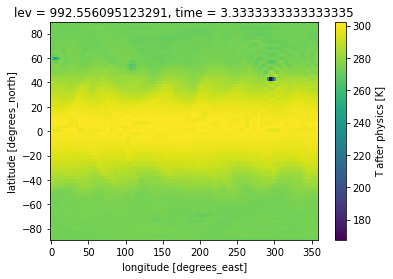

In [8]:
cam_ds.TAP.isel(time=-1, lev=-1).plot()

In [9]:
%%output holomap='scrubber'
anim(cam_ds.TAP.isel(lev=-1, time=slice(None, None, 10)), 
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True)

:HoloMap   [time]
   :Image   [lon,lat]   (TAP)

In [41]:
%%output holomap='scrubber'
anim(cam_ds.TAP.isel(time=slice(-40, None, 2)).sel(lat=60, method='nearest'), dims=['lon', 'lev'],
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True)

:HoloMap   [time]
   :Image   [lon,lev]   (TAP)

In [42]:
%%output holomap='scrubber'
anim(cam_ds.TPHYSTND.isel(time=slice(-40, None, 2)).sel(lat=60, method='nearest'), dims=['lon', 'lev'],
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True)

:HoloMap   [time]
   :Image   [lon,lev]   (TPHYSTND)

In [30]:
%%output holomap='scrubber'
anim(cam_ds.TPHYSTND.isel(lev=-1, time=slice(None, None, 5)), 
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True)

:HoloMap   [time]
   :Image   [lon,lat]   (TPHYSTND)

In [32]:
%%output holomap='scrubber'
anim(cam_ds.LHFLX.isel(time=slice(None, None, 5)), 
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True)

:HoloMap   [time]
   :Image   [lon,lat]   (LHFLX)

In [36]:
%%output holomap='scrubber'
anim(cam_ds.TPHYSTND.max('lon').isel(time=slice(-20, None)), 
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True, dims=['lat', 'lev'])

:HoloMap   [time]
   :Image   [lat,lev]   (TPHYSTND)

In [12]:
%%output holomap='scrubber'
anim(cam_ds.TPHYSTND.min('lon').isel(time=slice(-20, None)), 
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True, dims=['lat', 'lev'])

:HoloMap   [time]
   :Image   [lat,lev]   (TPHYSTND)

In [11]:
%%output holomap='scrubber'
anim(cam_ds.PHQ.max('lon').isel(time=slice(-20, None)), 
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True, dims=['lat', 'lev'])

:HoloMap   [time]
   :Image   [lat,lev]   (PHQ)

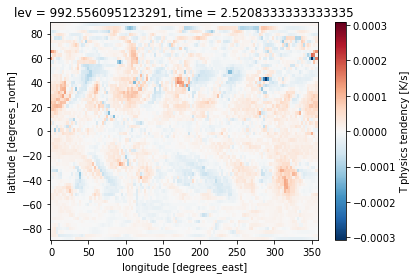

In [46]:
cam_ds.TPHYSTND.isel(time=-40, lev=-1).plot()

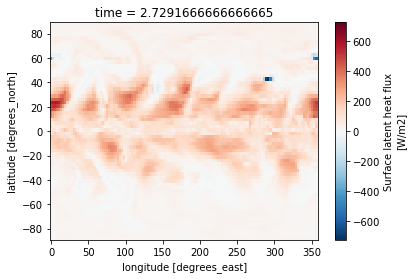

In [56]:
cam_ds.LHFLX.isel(time=-30).plot()

In [13]:
ilat = np.argmin(cam_ds.NNDT.isel(time=-30, lev=-1).min('lon').values)
ilon = np.argmin(cam_ds.NNDT.isel(time=-30, lev=-1).min('lat').values)
ilat, ilon, cam_ds.lat[ilat], cam_ds.lon[ilon]

(47, 103, <xarray.DataArray 'lat' ()>
 array(43.254195)
 Coordinates:
     lat      float64 43.25
 Attributes:
     long_name:  latitude
     units:      degrees_north, <xarray.DataArray 'lon' ()>
 array(289.6875)
 Coordinates:
     lon      float64 289.7
 Attributes:
     long_name:  longitude
     units:      degrees_east)

In [14]:
t=-30
in_vec = np.concatenate([
    cam_ds.NNQBP.isel(time=t, lat=ilat, lon=ilon, lev=slice(14, None)).values,
    cam_ds.NNTBP.isel(time=t, lat=ilat, lon=ilon, lev=slice(14, None)).values,
    cam_ds.NNVBP.isel(time=t, lat=ilat, lon=ilon).values,
    cam_ds.NNPS.isel(time=t, lat=ilat, lon=ilon).values[None],
    cam_ds.NNSOLIN.isel(time=t, lat=ilat, lon=ilon).values[None],
    cam_ds.NNSHF.isel(time=t, lat=ilat, lon=ilon).values[None],
    cam_ds.NNLHF.isel(time=t, lat=ilat, lon=ilon).values[None],
])[None, :]

In [22]:
in_vec_trans = input_transform.transform(in_vec)

In [23]:
from cbrain.model_diagnostics import *

In [24]:
J = get_jacobian(in_vec_trans[0], model)

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
in_vars

['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

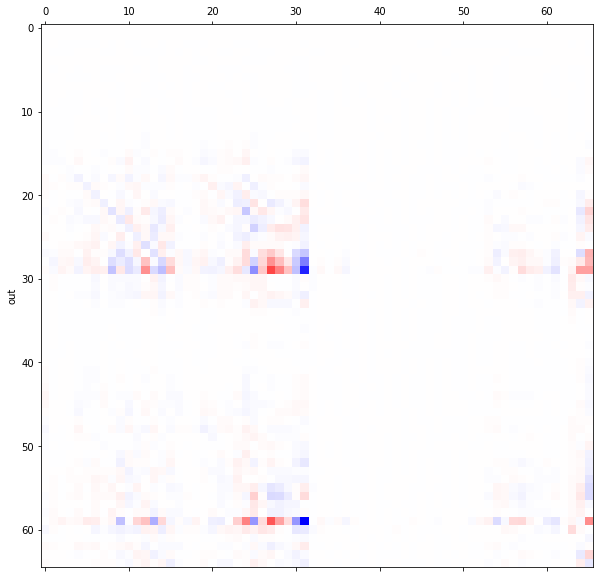

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(J, vmin=-5, vmax=5, cmap='bwr')
plt.ylabel('out')
plt.xticks()

In [27]:
from numpy import linalg as LA

In [29]:
J.shape

(65, 66)

In [32]:
out_idxs=np.concatenate([np.arange(14, 30),  np.arange(44, 60)]); out_idxs

array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [35]:
J[:32, out_idx].shape

(32, 32)

In [ ]:
plt.mat

In [33]:
w, v = LA.eig(J[:32, out_idx])

## 32 column run

In [65]:
cam32_ds = xr.open_mfdataset(CAMDIR+ 'debug32.cam2.h1.*.nc', 
                           decode_times=False, concat_dim='time')
cam32_ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 128)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) float64 0.0 0.02083 0.04167 ... 2.604 2.625 2.646
Dimensions

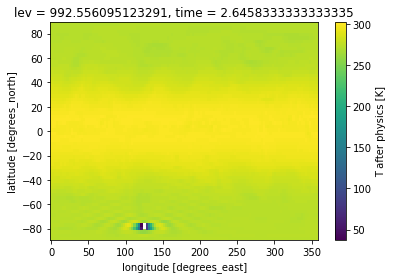

In [66]:
cam32_ds.TAP.isel(time=-1, lev=-1).plot()

In [67]:
%%output holomap='scrubber'
anim(cam32_ds.TPHYSTND.isel(lev=-1, time=slice(None, None, 5)), 
     fig_inches=(15,10),# cmap='bwr', 
     colorbar=True)

:HoloMap   [time]
   :Image   [lon,lat]   (TPHYSTND)

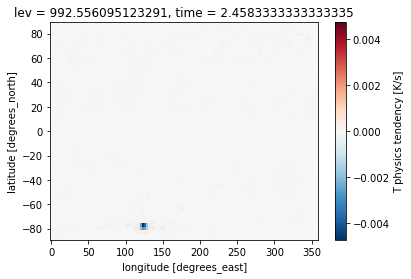

In [69]:
cam32_ds.TPHYSTND.isel(time=-10, lev=-1).plot()

In [70]:
ilat = np.argmin(cam32_ds.NNDT.isel(time=-10, lev=-1).min('lon').values)
ilon = np.argmin(cam32_ds.NNDT.isel(time=-10, lev=-1).min('lat').values)
ilat, ilon, cam_ds.lat[ilat], cam_ds.lon[ilon]

(4, 44, <xarray.DataArray 'lat' ()>
 array(-76.7369)
 Coordinates:
     lat      float64 -76.74
 Attributes:
     long_name:  latitude
     units:      degrees_north, <xarray.DataArray 'lon' ()>
 array(123.75)
 Coordinates:
     lon      float64 123.8
 Attributes:
     long_name:  longitude
     units:      degrees_east)

In [83]:
t=2
in_vec = np.concatenate([
    cam32_ds.NNQBP.isel(time=t, lat=ilat, lon=ilon, lev=slice(14, None)).values,
    cam32_ds.NNTBP.isel(time=t, lat=ilat, lon=ilon, lev=slice(14, None)).values,
    cam32_ds.NNVBP.isel(time=t, lat=ilat, lon=ilon).values,
    cam32_ds.NNPS.isel(time=t, lat=ilat, lon=ilon).values[None],
    cam32_ds.NNSOLIN.isel(time=t, lat=ilat, lon=ilon).values[None],
    cam32_ds.NNSHF.isel(time=t, lat=ilat, lon=ilon).values[None],
    cam32_ds.NNLHF.isel(time=t, lat=ilat, lon=ilon).values[None],
])[None, :]

In [84]:
in_vec_trans = input_transform.transform(in_vec)

In [85]:
from cbrain.model_diagnostics import *

In [86]:
J = get_jacobian(in_vec_trans[0], model)

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [87]:
in_vars

['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

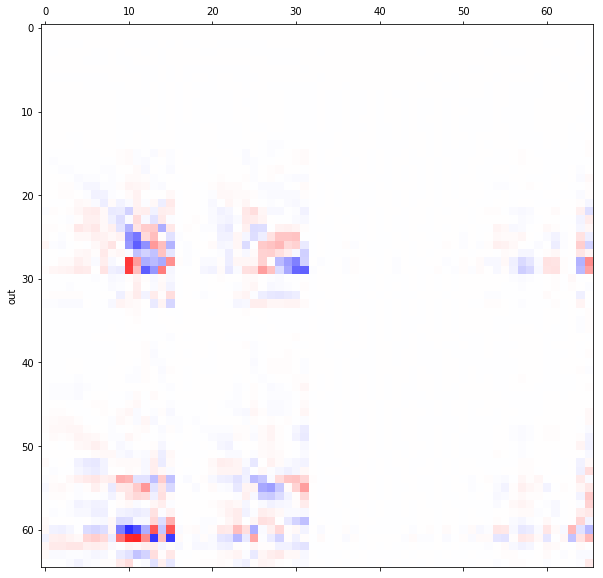

In [88]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(J, vmin=-5, vmax=5, cmap='bwr')
plt.ylabel('out')
plt.xticks()